In [1]:
#MLP to predict next char in sequence. 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for figs
%matplotlib inline

In [2]:
words = open('../lecture 2/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#building the vocab of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
#let's build the dataset
block_size = 3 #context length: how many chars do we take to predict the next one?
X,Y = [], []
for w in words[:5]:
    #print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape, X.dtype, Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [9]:
#27 possible chars, embed them in a lower dimensional space. each one of our 27 chars will have a 2D embedding
C = torch.randn((27,2))

In [11]:
C

tensor([[ 0.9462, -0.5067],
        [-0.0402,  0.3951],
        [ 1.4996,  0.5985],
        [-0.6082, -0.2061],
        [ 0.2354,  0.5555],
        [-0.5618,  1.3183],
        [ 0.8837,  0.2055],
        [ 0.1672,  0.0846],
        [ 0.6921,  0.8570],
        [ 0.2528,  1.2388],
        [-0.1892,  0.5280],
        [-0.3911,  1.6711],
        [ 0.9250,  0.0251],
        [ 0.5800, -0.2808],
        [ 0.4135,  0.0723],
        [-0.9043, -0.7419],
        [ 0.6941,  0.9938],
        [-0.9405, -0.8687],
        [ 1.0239, -1.4028],
        [ 0.6369, -0.4191],
        [-0.0388, -0.2023],
        [-0.1990, -0.2938],
        [-1.4533, -0.3917],
        [ 0.3631,  0.2210],
        [ 2.2297, -1.2885],
        [ 0.1771, -1.4301],
        [-0.5606,  0.1327]])

In [12]:
C[5]

tensor([-0.5618,  1.3183])

In [13]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C #THIS IS THE SAME RESULT BECAUSE OF HOW MATMUL WORKS! ITS AN ELEMENTWISE MULTIPLICATION OF EACH ROW. THE ONEHOT VECTOR IS JUST 
                                                      #ALL ZEROS AND A 1 FOR THE CORRESPONDING NUMBER, SO THE MATMUL WE DO HERE JUST MASKS OUT THE ENTIRE THING EXCEPT FOR THE ELEMENT WE WANT
                                                      #We won't do this because its completely unneccesary but my third eye has been opened

tensor([-0.5618,  1.3183])

In [14]:
C[torch.tensor([5,6,7,7,7,7])] #this is just to show that you can index into a pytorch tensor with a different tensor, which is why the following works:

tensor([[-0.5618,  1.3183],
        [ 0.8837,  0.2055],
        [ 0.1672,  0.0846],
        [ 0.1672,  0.0846],
        [ 0.1672,  0.0846],
        [ 0.1672,  0.0846]])

In [15]:
C[X] #oh my god

tensor([[[ 0.9462, -0.5067],
         [ 0.9462, -0.5067],
         [ 0.9462, -0.5067]],

        [[ 0.9462, -0.5067],
         [ 0.9462, -0.5067],
         [-0.5618,  1.3183]],

        [[ 0.9462, -0.5067],
         [-0.5618,  1.3183],
         [ 0.5800, -0.2808]],

        [[-0.5618,  1.3183],
         [ 0.5800, -0.2808],
         [ 0.5800, -0.2808]],

        [[ 0.5800, -0.2808],
         [ 0.5800, -0.2808],
         [-0.0402,  0.3951]],

        [[ 0.9462, -0.5067],
         [ 0.9462, -0.5067],
         [ 0.9462, -0.5067]],

        [[ 0.9462, -0.5067],
         [ 0.9462, -0.5067],
         [-0.9043, -0.7419]],

        [[ 0.9462, -0.5067],
         [-0.9043, -0.7419],
         [ 0.9250,  0.0251]],

        [[-0.9043, -0.7419],
         [ 0.9250,  0.0251],
         [ 0.2528,  1.2388]],

        [[ 0.9250,  0.0251],
         [ 0.2528,  1.2388],
         [-1.4533, -0.3917]],

        [[ 0.2528,  1.2388],
         [-1.4533, -0.3917],
         [ 0.2528,  1.2388]],

        [[-1.4533, -0

In [16]:
C[X].shape

torch.Size([32, 3, 2])

In [17]:
X[13,2]

tensor(1)

In [18]:
C[X][13,2]

tensor([-0.0402,  0.3951])

In [19]:
C[1]

tensor([-0.0402,  0.3951])

In [20]:
#Pytorch embedding is awesome. 
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [21]:
W1 = torch.randn((6,100)) #100 neurons
b1 = torch.randn(100)

In [22]:
emb @ W1 + b1 #doesn't work currently, dimensional issues

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [24]:
torch.cat([emb[:,0,:],  emb[:,1,:], emb[:,2,:]],1).shape

torch.Size([32, 6])

In [25]:
#now our embeddings have the dim we want, but its hideous, we're putting values in directly and it will not work if we decide to change the length of our context window (its currently 3)
torch.cat(torch.unbind(emb,1), 1).shape #this is better than the first one. its still inefficient because it creates a new tensor and a whole bunch of new memory

torch.Size([32, 6])

In [26]:
#calling .view() is extremely efficient due to shadow magic purposes. 
emb.shape

torch.Size([32, 3, 2])

In [27]:
emb.view(32,6)  == torch.cat(torch.unbind(emb,1), 1)#this is basically the concatenation operation  we were looking for

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [28]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #this works now!  (putting in -1 in the first arg of .view( ) makes pytorch infer what dimension this should have. neat)

In [29]:
h.shape

torch.Size([32, 100])

In [30]:
h

tensor([[ 0.7635,  0.9935, -0.8695,  ..., -0.3361, -0.9786, -0.9986],
        [ 0.9153,  0.8431,  0.1323,  ...,  0.9959, -0.9963, -0.9984],
        [ 0.9520,  0.9442, -0.7971,  ..., -0.7453, -0.0199, -0.9985],
        ...,
        [ 0.9216,  0.7273,  0.2481,  ..., -0.1949,  0.8510, -0.9960],
        [ 0.8035,  0.8650, -0.8993,  ...,  0.9653, -0.9987, -0.9862],
        [ 0.8086,  0.8922, -0.9243,  ...,  0.7107, -0.9657, -0.8813]])

In [31]:
#a note on broadcasting and making sure that it works
print((emb.view(-1,6)@W1).shape)
print(b1.shape)
#We basically have 
# 32,100
#  1,100 , this creates a "fake" dimension of 1 to make the addition possible. 100 aligns with 100, we're good. good practice to check broadcasting semantics

torch.Size([32, 100])
torch.Size([100])


In [32]:
W2 = torch.randn((100,27)) #27 neurons, this is the final layer of our network
b2 = torch.randn(27)
logits = h @ W2 + b2

In [33]:
logits.shape

torch.Size([32, 27])

In [38]:
logits

tensor([[-19.5653,  -4.8910,  19.1921,  -1.2431,   9.5596,  -5.4695,   5.1664,
          -1.7774, -13.7921, -13.9384,   7.7038,  11.2128,   2.1285,   3.2638,
          -1.9628, -10.6032,  -1.2184,  -5.0236,   9.9111,   0.6759,   7.7261,
          18.7083,  -3.7293,  -0.9092,   7.0308,  10.2050,  19.1433],
        [-16.2956,  -3.4812,  -9.5039,  -5.9267,   6.8686, -20.5129,  -8.8153,
           8.4786,  -1.4425,  -6.6246, -13.2913, -10.9136,   6.4823,   8.2476,
          -3.5762,  -4.0564,  -2.8164,  -3.8858,   1.2694,  -5.3500,   0.5172,
           4.3221,  -3.1008,   5.6820,   3.0424,  16.8611,   6.3647],
        [  0.4506,  -6.6771,  19.4337,   0.3260,   5.5302,  13.3023,  14.5765,
         -16.0236,  -4.3529,   5.0645,  -6.3898,   6.0291,   4.5442,   2.8441,
           7.8691,  -5.8949,  -5.8795,   4.9970,   3.2907,   7.9450,  10.8360,
          11.0560,  -7.6015,   6.1357, -13.9982,   4.1470,   6.7296],
        [-16.2812,  12.0858,   6.3840,   9.1431,   0.0301,  -2.7241,   9.1905,


In [34]:
counts = logits.exp()

In [35]:
prob = counts / counts.sum(1, keepdims = True)

In [36]:
#Previous two steps was our softmax
prob.shape

torch.Size([32, 27])

In [37]:
prob[0].sum() #checking that softmax has worked

tensor(1.)

In [39]:
#we have the actual layer that comes next. it comes from Y, which is the identity of the next char that we wanna predict. we wanna index into the rows of prob and each row, we'd like to pluck
#out the probablility assigned to the next character
prob[torch.arange(32),Y]

tensor([7.5817e-12, 1.8153e-04, 6.1766e-08, 3.2365e-02, 1.2857e-13, 4.4692e-14,
        5.3919e-05, 1.9440e-13, 2.0562e-08, 2.1440e-06, 8.0756e-02, 1.8104e-07,
        1.3521e-11, 3.4430e-07, 9.7000e-04, 8.9237e-03, 1.5914e-15, 1.7794e-12,
        3.1821e-09, 2.1881e-09, 9.1686e-10, 6.9760e-05, 9.7143e-08, 1.1602e-03,
        2.1502e-14, 3.5374e-09, 6.2832e-14, 1.7573e-09, 2.3807e-08, 5.1272e-08,
        2.6262e-12, 3.4632e-07])

In [ ]:
loss = -prob[torch.arange(32),Y].log().mean() #NLL! 
loss

tensor(18.2943)

In [41]:
#Rewrite to make more respectable
X.shape, Y.shape #Dataset

(torch.Size([32, 3]), torch.Size([32]))

In [42]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [43]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

3481

In [44]:
for p in parameters:
    p.requires_grad = True

In [45]:
#This is basically very bad crossentropy. we just use the torch function instead. explained a bit more in the cell below this one 
logits_test = torch.tensor([-5,-3,0,5]) + 1#too positives of values give inf, we get out of our range exponentiating like this. you can add an arbitrary constant to all of ur logits. prebuilt crossentropy does this for ur most positive logit to make sure we don't get such a large count that its infintie
counts_t = logits_test.exp()
probs_T = counts_t / counts_t.sum()
probs_T

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [75]:
for _ in range(10):
#forward pass: prebuilt crossentropy instead of doing it this awful way:
    emb = C[X] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #pytorch also subtracts the max value from each value so we don't run into numerical awfulness by acidentally doing exp(100) which makes our integer representation shit itself into an inf
    print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1 * p.grad

print("Final:" + str(loss.item()))

0.2527373135089874
0.25273633003234863
0.25273650884628296
0.2527354955673218
0.2527356743812561
0.2527346611022949
0.25273483991622925
0.25273382663726807
0.2527340054512024
0.252733051776886
Final:0.252733051776886


In [155]:
#let's build the dataset
block_size = 3 #context length: how many chars do we take to predict the next one?
X,Y = [], []
for w in words:
    #print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [162]:
#we overfit one batch in the example above. before when initialising out X and Y, we had words[:5], we're gonna get rid of the slicing and just use the entire dataset. 
#Once we did train on the entire dataset in one go, as we saw above, it was incredibly slow. around a second per epoch, which is bad if we want thousands. 
#we gotta do batching. rewriting model below so we have both versions for educational purposes
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [163]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

3481

In [164]:
for p in parameters:
    p.requires_grad = True

In [152]:
#below we figured out through trial and error that the best LR is prolly between 0.001 and 1. lets use that as a search space
lrE= torch.linspace(-3,0,1000)
lrs = 10**lrE
#lrs

In [169]:
lri = []
lossi = []
for i in range(10000):
#forward pass: prebuilt crossentropy instead of doing it this awful way, AND WITH BATCHING :) 

    #mninibatch construct
    ix = torch.randint(0,X.shape[0], (32,)) #generates 32 random numbers between 0 and the highest val number in X. indices that we will pass into C[x] below to grab 32 random examples from our dataset   
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Y[ix]) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update, but with learning rate indexing over our linear jumps over the exponents of our learning rate range
    #lr = lrs[i]
    lr = 0.01 #we did a search for the best LR and found that its exponent was optimal at -1, so we know that 0.1 is a pretty good learning rate. we do a LR decay after running a couple 10 thousand of each LR. 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats to find best LR
    #lri.append(lrE[i])
    #lossi.append(loss.item())

print("Final:" + str(loss.item()))

Final:2.254077196121216


Text(0, 0.5, 'Loss for corresponding learning rate')

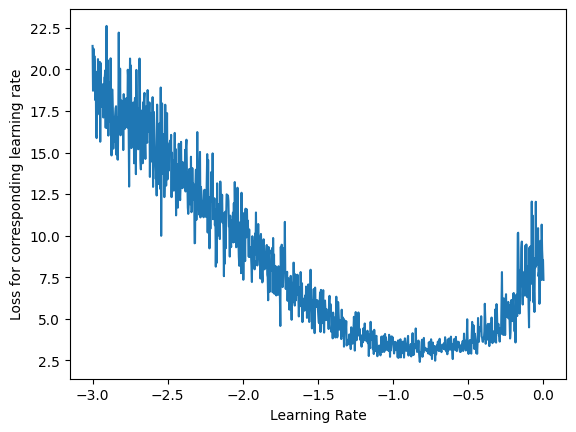

In [146]:
plt.plot(lri,lossi)
plt.xlabel("Learning Rate")
plt.ylabel("Loss for corresponding learning rate")

In [170]:
#above is the loss for only one minibatch. let's evaluate for all of X and all of Y
emb = C[X]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Y)
loss

tensor(2.3120, grad_fn=<NllLossBackward0>)

In [171]:
#now obviously we haven't done a train test split. this is bad. 
#training split, dev/validation split, test split
#80%, 10%, 10%
#80% is used to optimize parameters, validation split is used to optimize hyperparameters, test split is for testing
def build_dataset(words):
    block_size = 3
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [172]:
#Now made respectable ver2:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [173]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [174]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

3481

In [175]:
for p in parameters:
    p.requires_grad = True

In [176]:
#below we figured out through trial and error that the best LR is prolly between 0.001 and 1. lets use that as a search space
lrE= torch.linspace(-3,0,1000)
lrs = 10**lrE

In [181]:
lri = []
lossi = []
for i in range(10000):
#forward pass: prebuilt crossentropy instead of doing it this awful way, AND WITH BATCHING :) 

    #mninibatch construct
    ix = torch.randint(0,Xtr.shape[0], (32,)) #generates 32 random numbers between 0 and the highest val number in X. indices that we will pass into C[x] below to grab 32 random examples from our dataset   
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix]) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update, but with learning rate indexing over our linear jumps over the exponents of our learning rate range
    #lr = lrs[i]
    lr = 0.01 #we did a search for the best LR and found that its exponent was optimal at -1, so we know that 0.1 is a pretty good learning rate. we do a LR decay after running a couple 10 thousand of each LR. 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats to find best LR
    #lri.append(lrE[i])
    #lossi.append(loss.item())

print("Final:" + str(loss.item()))

Final:2.1239678859710693


In [182]:
#above is the loss for only one minibatch. let's evaluate for Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.3344, grad_fn=<NllLossBackward0>)

In [183]:
#above is the loss for only one minibatch. let's evaluate for Xte and Yte
emb = C[Xte]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Yte)
loss

tensor(2.3360, grad_fn=<NllLossBackward0>)

In [200]:
#Looks like we're underfitting; validation loss and test loss seem to be identical. let's make this network bigger :) 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300),generator=g)
b1 = torch.randn(300,generator=g)
W2 = torch.randn((300,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [201]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

10281

In [202]:
for p in parameters:
    p.requires_grad = True

In [203]:
#below we figured out through trial and error that the best LR is prolly between 0.001 and 1. lets use that as a search space
lrE= torch.linspace(-3,0,1000)
lrs = 10**lrE

In [199]:
lossi = []
stepi = []

In [206]:

for i in range(25000):
#forward pass: prebuilt crossentropy instead of doing it this awful way, AND WITH BATCHING :) 

    #mninibatch construct
    ix = torch.randint(0,Xtr.shape[0], (32,)) #generates 32 random numbers between 0 and the highest val number in X. indices that we will pass into C[x] below to grab 32 random examples from our dataset   
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix]) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update, but with learning rate indexing over our linear jumps over the exponents of our learning rate range
    #lr = lrs[i]
    lr = 0.005 #we did a search for the best LR and found that its exponent was optimal at -1, so we know that 0.1 (at least to begin with) is a pretty good learning rate. we do a LR decay after running a couple 10 thousand of each LR. 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats to find best LR
    stepi.append(i)
    #lri.append(lrE[i])
    lossi.append(loss.item())

print("Final:" + str(loss.item()))

Final:2.274174690246582


Text(0, 0.5, 'Loss (Negative Logarithmic Likelihood)')

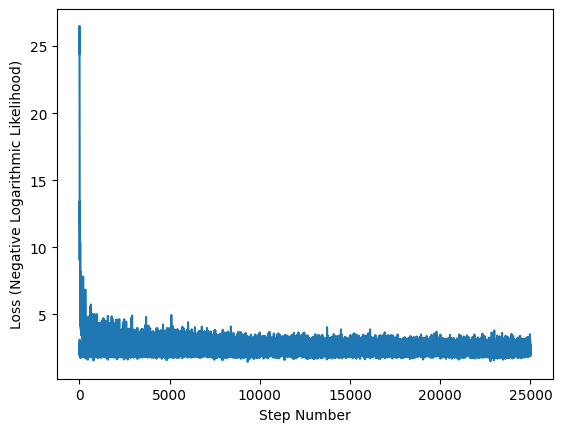

In [207]:
plt.plot(stepi,lossi)
plt.xlabel("Step Number")
plt.ylabel("Loss (Negative Logarithmic Likelihood)")

In [208]:
#let's evaluate for Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.2979, grad_fn=<NllLossBackward0>)

In [210]:
#let's evaluate for Xte and Yte
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.2972, grad_fn=<NllLossBackward0>)

In [209]:
#let's evaluate for Xte and Yte
emb = C[Xte]
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Yte)
loss

tensor(2.3006, grad_fn=<NllLossBackward0>)

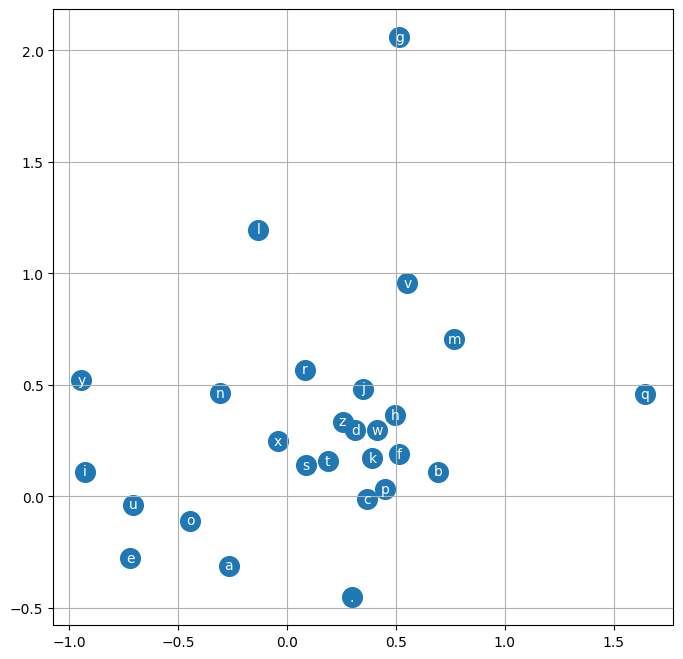

In [77]:
#a potential bottleneck is our dimensionality reduction of the look-up table down to 2 dimensions. this could lead to information loss that our model could use to make something even better.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha='center', va='center',color='white')
plt.grid('minor')

In [211]:
#now we're gonna be able to scale up the embedding size and we won't be able to visualise it anymore, but it will lead to an improvement in our performance. 
#we're still underfitting. we make model bigger, still underfitting, so embedding vectors might be bottleneck
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2= torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [212]:
sum(p.nelement() for p in parameters) #number of params total for model :=)

11897

In [213]:
for p in parameters:
    p.requires_grad = True

In [214]:
lri = []
lossi = []
stepi = []

In [215]:
for i in range(200000):
#forward pass: prebuilt crossentropy instead of doing it this awful way, AND WITH BATCHING :) 

    #mninibatch construct
    ix = torch.randint(0,Xtr.shape[0], (32,)) #generates 32 random numbers between 0 and the highest val number in X. indices that we will pass into C[x] below to grab 32 random examples from our dataset   
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,30)@W1 + b1) #(32,100)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix]) #MUCH better, do this. makes everything much more efficient, the backwards pass gets faster too. This is explored in the cell above
    #print(loss.item())
    #counts = logits.exp()
    #prob = counts / counts.sum(1,keepdims = True)
    #loss = -prob[torch.arange(32),Y].log().mean()

    #backward pass! 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update, but with learning rate indexing over our linear jumps over the exponents of our learning rate range
    #lr = lrs[i]
    lr = 0.1 if i <100000 else 0.01 #we did a search for the best LR and found that its exponent was optimal at -1, so we know that 0.1 (at least to begin with) is a pretty good learning rate. we do a LR decay after running a couple 10 thousand of each LR. 
    for p in parameters:
        p.data += -lr * p.grad
    #tracking stats to find best LR
    stepi.append(i)
    #lri.append(lrE[i])
    lossi.append(loss.log10().item())

print("Final:" + str(loss.item()))

Final:2.1368567943573


Text(0, 0.5, 'Loss (Negative Logarithmic Likelihood)')

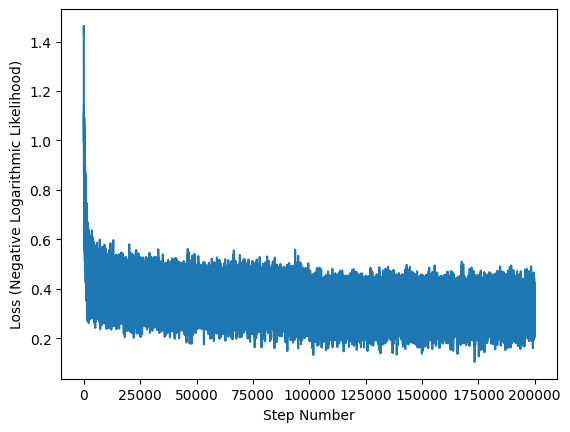

In [216]:
plt.plot(stepi,lossi)
plt.xlabel("Step Number")
plt.ylabel("Loss (Negative Logarithmic Likelihood)")

In [217]:
#let's evaluate for Xdev and Ydev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1738, grad_fn=<NllLossBackward0>)

In [219]:
#let's evaluate for Xte and Yte
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1368, grad_fn=<NllLossBackward0>)

In [218]:
#let's evaluate for Xte and Yte
emb = C[Xte]
h = torch.tanh(emb.view(-1,30)@W1 + b1) #(32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits,Yte)
loss

tensor(2.1804, grad_fn=<NllLossBackward0>)

In [222]:
#Let's sample the model finally and enjoy the fruits of our labour
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
kmyanniee.
med.
ryla.
rethan.
emdon.
graderedielin.
shi.
jen.
eden.
van.
narielle.
malaia.
noshiberlihiriel.
kindreelynn.
nochorius.
kynder.
yarue.
els.
kayshia.


In [224]:
#Let's sample the model finally and enjoy the fruits of our labour

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

kayson.
zamarias.
amyira.
aliyah.
ede.
lauli.
jazasyayn.
timontangreel.
wellena.
meisous.
khaly.
klin.
roson.
aydelin.
kahtrag.
yehilayah.
ison.
khidy.
jak.
ainya.
